# Imports

In [2]:
import requests
import json
import os
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# create labels data for annotated images

In [3]:
JSON_PATH = r'C:\Users\drkab\Documents\data_scraper\data\friends_annotated_1'
LBL = r'C:\Users\drkab\Documents\data_scraper\data\friends\labels'
from pathlib import Path
os.chdir(JSON_PATH)

In [4]:
d = {}
for filename in os.listdir(JSON_PATH):
    if filename.endswith('.json'):
        f = open(filename,)
        data = json.load(f)
        img_w = data['asset']['size']['width']
        img_h =data['asset']['size']['height']
        imgfile = data['asset']['name']
        c_id = []
        top =[]
        right =[]
        bottom =[]
        left =[]
        for obj in data['regions']:
            lbl = obj['tags'][0]
            l = obj['boundingBox']['left']
            t = obj['boundingBox']['top']
            w = obj['boundingBox']['width']
            h = obj['boundingBox']['height']
            
            if lbl in ['chandler', 'joey', 'phoebe', 'monika', 'rachel', 'ross']:
                c_id.append(lbl)
                #c_id.append(['gloves', 'faceshield'].index(lbl))
                right.append(l + w)
                bottom.append(t + h)
                top.append(t)
                left.append(l)
                
        text = ""
        for i in range(len(c_id)):
            text = text+str(c_id[i])+' '+str(top[i])+' '+str(right[i])+' '+str(bottom[i])+' '+str(left[i])+'\n'

#         if text:
            fname = imgfile
            truth = {
                'bbox': [top[i], right[i], bottom[i], left[i]],
                'lbl': c_id[i]
            }
            if fname in d:
                d[fname].append(truth)
            else:
                d[fname] = [truth]
#             if Path(LBL+'\\'+imgfile+".txt").is_file():
#                 print(imgfile)
#                 with open(LBL+'\\'+imgfile+".txt", "a") as f:
#                     f.write(text)
#             else:
#                 with open(LBL+'\\'+imgfile+".txt", "w") as f:
#                     f.write(text)


print("writing done.")
# print(d)

writing done.


In [5]:
d['friends_10.jpg']

[{'bbox': [151.64008884803923,
   113.19779462439698,
   245.245481004902,
   35.14817367332874],
  'lbl': 'rachel'},
 {'bbox': [153.19155943627453,
   241.90213645761546,
   258.17440257352945,
   159.20055134390077],
  'lbl': 'joey'},
 {'bbox': [144.39989276960785,
   485.87181254307376,
   259.72587316176475,
   401.1026878015162],
  'lbl': 'chandler'},
 {'bbox': [153.19155943627453,
   608.3735354927637,
   250.93420649509807,
   525.1550654720883],
  'lbl': 'phoebe'},
 {'bbox': [152.67440257352942,
   356.65058580289457,
   250.41704963235296,
   286.8711233631978],
  'lbl': 'monika'},
 {'bbox': [153.19155943627453,
   739.145416953825,
   268.0003829656863,
   661.0957960027567],
  'lbl': 'ross'}]

# Predicted results

In [6]:
r = requests.get('http://127.0.0.1:8000/admin/compile_predictions')
r.status_code

200

In [7]:
data = r.text
parse_json = json.loads(data)

In [8]:
lbl_pred = []
fname_pred = []
for k,faces in parse_json.items():
    t = []
    fname_pred.append(k)
    for f in faces:
#         print(f['lbl'])
        if f['pred_indv_id'] > 0:
            t.append(f['pred_indv_id'])
    lbl_pred.append(t)

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb_pred = MultiLabelBinarizer()
y_pred = mlb_pred.fit_transform(lbl_pred)
y_pred

array([[0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1]])

In [10]:
mlb_pred.classes_

array([1, 2, 3, 4, 5, 6])

# Ground truth

In [11]:
lbl_truth = []
fname_truth = []
for file in fname_pred:
    t = []
    fname_truth.append(file)
    if file in d:
        for f in d[file]:
            t.append(f['lbl'])
    lbl_truth.append(t)

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_true = mlb.fit_transform(lbl_truth)
y_true

array([[1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]])

In [13]:
mlb.classes_

array(['chandler', 'joey', 'monika', 'phoebe', 'rachel', 'ross'],
      dtype=object)

# Confusion matrix

The one-hot vector of ground truth and predictions are like image classification labels for each image.

In [14]:
labels = ['chandler', 'joey', 'monika', 'phoebe', 'rachel', 'ross']
cm = multilabel_confusion_matrix(y_true, y_pred)

In [15]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

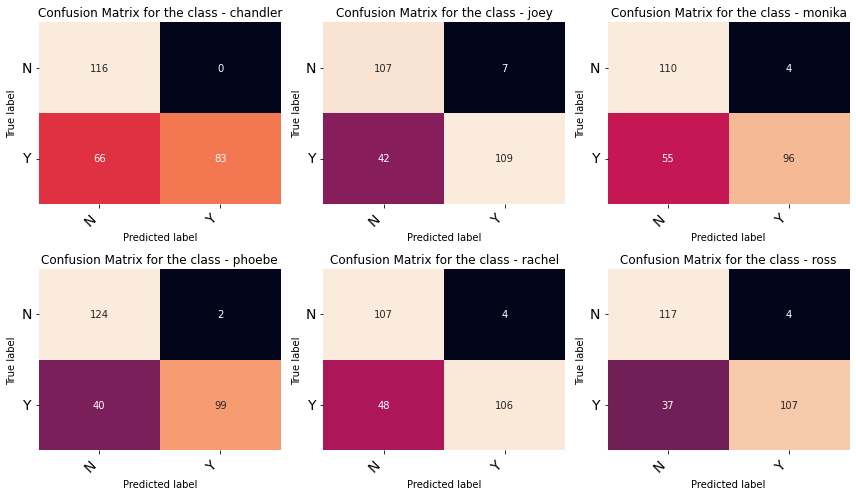

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [18]:
print('classes: ', labels)
tn = cm[:, 0, 0]
tp = cm[:, 1, 1]
fn = cm[:, 1, 0]
fp = cm[:, 0, 1]
recall = tp / (tp + fn)
print('recall: ',recall)
specificity = tn / (tn + fp)
print('specificity: ',specificity)
FPR = fp / (fp + tn)
print('FPR: ',FPR)
FNR = fn / (fn + tp)
print('FNR: ',FNR)
precision = tp/ (tp + fp)
print('precision: ',precision)

classes:  ['chandler', 'joey', 'monika', 'phoebe', 'rachel', 'ross']
recall:  [0.55704698 0.7218543  0.63576159 0.71223022 0.68831169 0.74305556]
specificity:  [1.         0.93859649 0.96491228 0.98412698 0.96396396 0.96694215]
FPR:  [0.         0.06140351 0.03508772 0.01587302 0.03603604 0.03305785]
FNR:  [0.44295302 0.2781457  0.36423841 0.28776978 0.31168831 0.25694444]
precision:  [1.         0.93965517 0.96       0.98019802 0.96363636 0.96396396]


# Confusion matrix for Face Recognition using IOU

In [19]:
# predicted labels including unknown faces
lbl_pred = []
fname_pred = []
for k,faces in parse_json.items():
    t = []
    fname_pred.append(k)
    for f in faces:
#         print(f['lbl'])
#         if f['pred_indv_id'] > 0:
        t.append(f['pred_indv_id'])
    lbl_pred.append(t)

In [20]:
# ground truth
bbox_truth = []
# fname_truth = []
lbl_map = {'chandler':1, 'joey':2, 'monika':3, 'phoebe':4, 'rachel':5, 'ross':6}
lbl_truth = []
for file in fname_pred:
    b = []
    l = []
    if file in d:
        for f in d[file]:
            l.append(lbl_map[f['lbl']])
            b.append(f['bbox'])
    bbox_truth.append(b)    
    lbl_truth.append(l)

In [21]:
# predicted
bbox_pred = []
for k,faces in parse_json.items():
    b = []
    for f in faces:
#         print(f['lbl'])
#         if f['pred_indv_id'] > 0:
        b.append(f['bbox'])
    bbox_pred.append(b)

In [ ]:
# top, right, bottom, left
# x1 0 = left 3
# y1 1= top 0
# w1 2= right - left 1 - 3
# h1 3= top - bottom 0-2

In [22]:
def intersection_over_union(gt_box, pred_box):
    inter_box_top_left = [max(gt_box[3], pred_box[3]), max(gt_box[0], pred_box[0])]
#     inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [min(gt_box[3]+(gt_box[1]-gt_box[3]), pred_box[3]+(pred_box[1]-pred_box[3])), 
                              min(gt_box[0]+(gt_box[0]-gt_box[2]), pred_box[0]+(pred_box[0]-pred_box[2]))]
#     inter_box_bottom_right = [min(gt_box[0]+gt_box[2], pred_box[0]+pred_box[2]), min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = (gt_box[1]-gt_box[3]) * (gt_box[0]-gt_box[2]) + (pred_box[1]-pred_box[3]) * (pred_box[0]-pred_box[2]) - intersection
#     union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection
    
    iou = intersection / union

    return iou

In [23]:
bbox_truth[0]

[[118.17153033088236, 103.7077877325982, 187.16050091911765, 50.1171605789111],
 [133.0612362132353, 281.8470020675396, 196.5906479779412, 228.2563749138525],
 [121.14947150735294,
  374.63818056512747,
  185.67153033088238,
  321.54376292212265],
 [132.56491268382354,
  541.3645761543763,
  192.62005974264707,
  507.62232942798073],
 [94.84432444852942, 647.553411440386, 160.85535386029414, 606.368022053756]]

In [24]:
# tp, fp, tn, fn
labels = ['unknown', 'chandler', 'joey', 'monika', 'phoebe', 'rachel', 'ross', 'undetected']
results = np.zeros((8, 8))
for i,fname in enumerate(fname_pred):
    res = np.zeros((8, 8))
    for j,plist in  enumerate(bbox_pred[i]):
        for k,tlist in enumerate(bbox_truth[i]):
            iou = intersection_over_union(plist,tlist)
            t_lbl = lbl_truth[i][k]
            if iou > 0.50:
                p_lbl = lbl_pred[i][j]
                res[p_lbl][t_lbl] += 1
            else:
                res[7][t_lbl] += 1
#     print(res)
    sub_extra =len(bbox_pred[i])-1
#     print(sub_extra)
    for l in range(8):
        res[7][l] = res[7][l]-sub_extra if res[7][l] > 0 else 0
#     print(res)
    results = results + res
results

array([[  0.,  37.,  10.,  21.,  15.,  19.,   2.,   0.],
       [  0.,  87.,   0.,   1.,   3.,   1.,   2.,   0.],
       [  0.,   5., 113.,   3.,   0.,   2.,   0.,   0.],
       [  0.,   4.,   3.,  99.,   5.,   0.,   3.,   0.],
       [  0.,   6.,   6.,   7., 105.,   1.,   4.,   0.],
       [  0.,   0.,   1.,   4.,   2., 112.,   1.,   0.],
       [  0.,   1.,   2.,   2.,  10.,   1., 113.,   0.],
       [  0., 167., 133., 132.,  95., 132., 121.,   0.]])

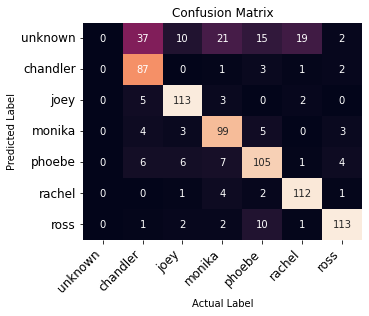

In [35]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
labels = ['unknown', 'chandler', 'joey', 'monika', 'phoebe', 'rachel', 'ross']
df_cm = pd.DataFrame(
        results[:7,:7], index=labels, columns=labels,
    )

heatmap = sns.heatmap(df_cm, annot=True, fmt=".3g",cbar=False)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
plt.title('Confusion Matrix')
plt.ylabel('Predicted Label')
plt.xlabel('Actual Label')
plt.show()